#### Imports

In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

%matplotlib inline

#### Import Data

In [3]:
with np.load("notMNIST.npz") as data:
    images, labels = data["images"], data["labels"]

In [4]:
num_classes = labels.max() - labels.min() + 1
num_classes

10

In [5]:
images.shape

(28, 28, 18720)

In [6]:
images.T.shape

(18720, 28, 28)

In [7]:
labels.shape

(18720, 1)

In [8]:
temp_img = images.T[1].T
temp_img.shape

(28, 28)

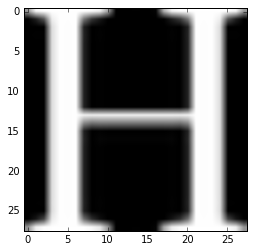

In [9]:
plt.imshow(temp_img, cmap=plt.gray())

In [10]:
print labels[1]

[7]


## Logistic Regression w/ Softmax

- Softmax output layer
- Log likelihood objective function
- Train with no reg., SGD and momentum
- Find good value for momentum hyper
- Plot log likelihood / errors of training and valid vs number of epochs
- Determine best time to stop training, and compute test errors on it

$$y(\mathbf{x}, \mathbf{w}) = \sigma (\mathbf{x}^T \mathbf{w} + b)$$

#### Set up data

In [11]:
images_re = images.reshape((images.shape[0] * images.shape[1], images.shape[2])).T
images_re.shape

(18720, 784)

In [12]:
training_size = 15000
validation_size = 1000

In [13]:
train_x = images_re[:training_size]
valid_x = images_re[training_size:training_size + validation_size]
test_x = images_re[training_size + validation_size:]

#### Create one-hot labels

In [14]:
labels.size

18720

In [15]:
labels[:10]

array([[4],
       [7],
       [5],
       [9],
       [9],
       [1],
       [0],
       [8],
       [5],
       [5]], dtype=uint8)

In [16]:
num_examples = labels.size
labels_one_hot = np.zeros((num_examples, labels.max() - labels.min() + 1))
labels_one_hot[np.arange(num_examples), labels[:num_examples].ravel()] = 1

In [17]:
labels_one_hot[:10]

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [18]:
train_y = labels_one_hot[:training_size]
valid_y = labels_one_hot[training_size:training_size + validation_size]
test_y = labels_one_hot[training_size + validation_size:]

#### Try sklearn

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(train_x, labels[:training_size].ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
lr.score(train_x, labels[:training_size].ravel())

0.93786666666666663

In [27]:
lr.score(valid_x, labels[training_size:training_size + validation_size].ravel())

0.878

In [29]:
lr.score(test_x, labels[training_size + validation_size:].ravel())

0.87169117647058825

#### Set up TF variables

In [34]:
#Placeholders
X = tf.placeholder("float", shape=(None, 28 * 28))
Targets = tf.placeholder("float", shape=(None, num_classes))

#Variables
W = tf.Variable(np.random.randn(28 * 28, num_classes).astype("float32"), name="weight")
b = tf.Variable(np.random.randn(num_classes).astype("float32"), name="bias")

In [35]:
logits = tf.add(tf.matmul(X, W), b)
Y = tf.nn.softmax(logits)

In [36]:
Y.get_shape()

TensorShape([Dimension(None), Dimension(10)])

#### Try with CE loss function

In [38]:
cost_batch = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Targets)
cost = tf.reduce_mean(cost_batch)

In [54]:
learning_rate = 0.01
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.99)
train_op = optimizer.minimize(cost)

In [55]:
correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Targets,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float32"))

In [56]:
sess = tf.InteractiveSession()

In [57]:
init = tf.initialize_all_variables()

In [58]:
sess.run(init)

In [59]:
num_epochs = 100
mini_batch_size = 100

In [60]:
train_error = []
valid_error = []

In [61]:
for epoch in range(num_epochs): 
    for i in range(training_size / mini_batch_size):
        batch_x = train_x[i * mini_batch_size: (i + 1) * mini_batch_size]
        batch_y = train_y[i * mini_batch_size: (i + 1) * mini_batch_size]

        cost_np, _ = sess.run([cost, train_op], feed_dict={X: batch_x, Targets: batch_y})

    #Display logs per epoch step
    if epoch % num_epochs / 100 == 0:
        cost_train, accuracy_train = sess.run([cost, accuracy], feed_dict={X: train_x, Targets: train_y})
        cost_valid, accuracy_valid = sess.run([cost, accuracy], feed_dict={X: valid_x, Targets: valid_y})
        
        train_error.append(accuracy_train)
        valid_error.append(accuracy_valid)
        
        print ("Epoch:%04d, cost=%0.9f, Train Accuracy=%0.4f, Eval Accuracy=%0.4f" %
           (epoch, cost_train, accuracy_train, accuracy_valid))

Epoch:0000, cost=39207.738281250, Train Accuracy=0.8697, Eval Accuracy=0.8720
Epoch:0001, cost=27133.898437500, Train Accuracy=0.8806, Eval Accuracy=0.8690
Epoch:0002, cost=19363.412109375, Train Accuracy=0.8800, Eval Accuracy=0.8650
Epoch:0003, cost=14848.763671875, Train Accuracy=0.8829, Eval Accuracy=0.8650
Epoch:0004, cost=14468.912109375, Train Accuracy=0.8748, Eval Accuracy=0.8490
Epoch:0005, cost=23067.462890625, Train Accuracy=0.8509, Eval Accuracy=0.8110
Epoch:0006, cost=24954.830078125, Train Accuracy=0.8570, Eval Accuracy=0.8300
Epoch:0007, cost=15156.181640625, Train Accuracy=0.8985, Eval Accuracy=0.8600
Epoch:0008, cost=19793.066406250, Train Accuracy=0.8554, Eval Accuracy=0.8160
Epoch:0009, cost=15333.002929688, Train Accuracy=0.8905, Eval Accuracy=0.8570
Epoch:0010, cost=25625.281250000, Train Accuracy=0.8521, Eval Accuracy=0.8050
Epoch:0011, cost=22523.697265625, Train Accuracy=0.8420, Eval Accuracy=0.7910
Epoch:0012, cost=15691.054687500, Train Accuracy=0.9039, Eval Ac

In [62]:
print(sess.run(accuracy, feed_dict={X: test_x, Targets: test_y}))

0.857353


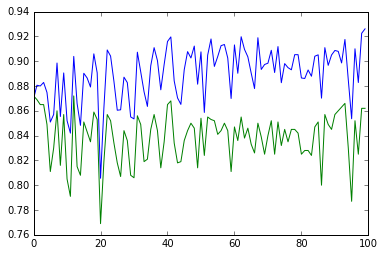

In [63]:
plt.plot(np.arange(100), train_error)
plt.plot(np.arange(100), valid_error)